## ML and DL Validation on existing results

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from econml.grf import CausalForest
from sklearn.compose import ColumnTransformer
from typing import List,  Dict, Any
from numpy import random
from scipy.stats import spearmanr, pearsonr
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor

c:\Users\TMHMXM447\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
codepath = Path().absolute()
basePath = codepath.parent
df = pd.read_csv(f"{basePath}/tp_seer_data_cleaned.csv")

#### TumorSize×Race interaction and inflection zones using SHAP on a ML model trained on RMST pseudo-values

In [3]:
def rmst_pseudo(df, time_col, event_col, tau):
    n = len(df)
    kmf = KaplanMeierFitter()
    def rmst(sub):
        kmf.fit(sub[time_col], sub[event_col])
        surv = kmf.survival_function_at_times(np.linspace(0, tau, 601)).values
        times = np.linspace(0, tau, 601)
        return np.trapezoid(surv, times)
    rmst_all = rmst(df)
    pseudo = np.zeros(n)
    for i in range(n):
        rmst_loo = rmst(df.drop(i))
        pseudo[i] = n * rmst_all - (n - 1) * rmst_loo
    return pseudo

df["RMST_60"] = rmst_pseudo(df, "Survival months", "event", 60)

In [4]:
for col in df.columns:
    if col in ["Age_Group_Broad", "Race", "County_Grouped","Chemo","Radiation","Radiation_original", "Income_Broad", "SummaryStage_98_17","NeoadjuvantResponse_10", 'Radiation_original',
               "Neoadj_status", "Neoadj_response", "NumMalignantTumors", "NumBenignTumors"]:
        print(df[col].value_counts()/len(df)*100)

SummaryStage_98_17
Unknown      39.037478
Localized    35.713088
Regional     21.644169
Distant       3.605265
Name: count, dtype: float64
Radiation
Yes    51.731366
No     48.268634
Name: count, dtype: float64
Chemo
Yes    73.191079
No     26.808921
Name: count, dtype: float64
NeoadjuvantResponse_10
Not Given    61.289511
Unknown      23.132389
PR            7.483022
CR            7.021883
NR            1.073195
Name: count, dtype: float64
NumMalignantTumors
1 Tumor      77.680892
2+ Tumors    22.319108
Name: count, dtype: float64
NumBenignTumors
0 Tumors     99.086107
≥1 Tumors     0.913893
Name: count, dtype: float64
Race
NHW         58.690366
Hispanic    15.565524
NHAPI       15.431374
NHB          9.281462
NHAIAN       1.031274
Name: count, dtype: float64
County_Grouped
Large Metro           67.820911
Medium/Small Metro    23.513876
Rural                  8.359185
Unknown                0.306028
Name: count, dtype: float64
Age_Group_Broad
40-59    46.629496
60-69    22.914396
70-7

In [5]:
df["Radiation"].replace({"Unknown": "No", "Refused": "No","Other": "Yes", "Beam": "Yes"}, inplace=True)
df["NumMalignantTumors"].replace({"1 Tumor": "1 Tumor", "2 Tumors": "2+ Tumors", "3+ Tumors": "2+ Tumors"}, inplace=True)
df["Neoadj_status"].replace({"Not Given": "No/unk", "Given": "Yes","Unknown": "No/unk"}, inplace=True)

In [6]:
cols_to_use = ["Age_Group_Broad", "Race", "County_Grouped","Chemo","Radiation", "Tumor_Size_Numeric", "NumMalignantTumors","Neoadj_status",
               "RMST_60", "event","Survival months","Income_Broad", "Tumor_Size_Granular"]
cat_cols = ["Age_Group_Broad", "Race", "County_Grouped","Chemo","Radiation","Income_Broad","NumMalignantTumors","Neoadj_status","Tumor_Size_Granular"]
for col in cat_cols:
    df[col] = df[col].astype('category')

df_model = df[cols_to_use].copy()
df_model = df_model.dropna(subset=["Survival months", "RMST_60", "Tumor_Size_Numeric", "event"])

conditions = [
    (df_model["Chemo"].str.lower() == "yes") & (df_model["Radiation"].str.lower() == "yes"),
    (df_model["Chemo"].str.lower() == "yes") & (df_model["Radiation"].str.lower() == "no"), 
    (df_model["Radiation"].str.lower() == "yes") & (df_model["Chemo"].str.lower() == "no"),
    (df_model["Radiation"].str.lower() == "no") & (df_model["Chemo"].str.lower() == "no")
]

choices = ["Both", "Chemo only", "RT only", "None"]

df_model["Treatment"] = np.select(conditions, choices, default="none")

DR_table = pd.read_excel(f"{basePath}/Statistical scripts/Propensity score and IPTW/DR_RMST60_by_SizeRACE.xlsx" )
DR_table["Arm1"] = DR_table["Arm1"].fillna("None")
DR_table["Arm0"] = DR_table["Arm0"].fillna("None")

In [102]:
df_model.head()

,Age_Group_Broad,Race,County_Grouped,Chemo,Radiation,Tumor_Size_Numeric,NumMalignantTumors,Neoadj_status,RMST_60,event,Survival months,Income_Broad,Tumor_Size_Granular,Treatment
0,80+,NHW,Large Metro,Yes,No,60,2+ Tumors,Yes,12.771697,1,19,">= $120,000",51-100 mm (T3),Chemo only
1,80+,NHB,Large Metro,No,No,10,2+ Tumors,No/unk,60.714147,0,90,"$100,000 - $119,999",6-10 mm (T1b),None
2,40-59,NHW,Large Metro,Yes,No,13,2+ Tumors,No/unk,60.714147,0,91,"$100,000 - $119,999",11-20 mm (T1c),Chemo only
3,40-59,NHW,Large Metro,Yes,No,19,2+ Tumors,Yes,60.340841,0,45,">= $120,000",11-20 mm (T1c),Chemo only
4,70-79,NHW,Large Metro,No,Yes,15,2+ Tumors,No/unk,60.714147,1,91,"$100,000 - $119,999",11-20 mm (T1c),RT only


In [103]:
DR_table.head()

,Tumor_Size_Granular,Race,Contrast,Arm1,Arm0,nA,n0,Total N,RMST60_arm1,RMST60_arm0,...,delta_aipw,ci_lo,ci_hi,p,ess_sw,smd_unw,smd_w,pi,w_trunc_low,w_trunc_high
0,0-5 mm (T1a),Hispanic,Both vs Chemo,Both,Chemo only,35,29,64,59.666667,60.000000,...,-3.130918,-8.292056,2.030221,0.234439,62.449626,0.241880,0.175621,0.546875,0.740135,1.291197
1,0-5 mm (T1a),Hispanic,Both vs None,Both,None,35,85,120,59.666667,58.645240,...,-2.383042,-6.624995,1.858910,0.270858,114.408882,0.359710,0.252214,0.291667,0.442284,1.379669
2,0-5 mm (T1a),Hispanic,Chemo vs None,Chemo only,None,29,85,114,60.000000,58.645240,...,2.752219,-0.842909,6.347347,0.133495,111.570017,0.248681,0.159067,0.254386,0.726979,1.324558
3,0-5 mm (T1a),Hispanic,Chemo vs RT,Chemo only,RT only,29,63,92,60.000000,59.106977,...,4.567762,0.029538,9.105986,0.048523,89.907904,0.260885,0.186701,0.315217,0.738956,1.351456
4,0-5 mm (T1a),Hispanic,RT vs None,RT only,None,63,85,148,59.106977,58.645240,...,-1.946280,-5.283768,1.391208,0.253044,144.438619,0.150340,0.074292,0.425676,0.739410,1.322979


In [ ]:
COVARS = ["Age_Group_Broad", "County_Grouped", "Income_Broad", "NumMalignantTumors", "Neoadj_status"]

X = df_model[COVARS].copy()
encoder = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), X.select_dtypes(include=['object', 'category']).columns),
            ('num', StandardScaler(), X.select_dtypes(include=['number']).columns)
        ],
        remainder='drop'
    )
X_enc = np.asarray(encoder.fit_transform(X))

vif = pd.DataFrame({
    "Variable": encoder.get_feature_names_out(COVARS),
    "VIF": [variance_inflation_factor(X_enc, i) for i in range(X_enc.shape[1])]
}).sort_values("VIF", ascending=False)

vif.head(10)

,Variable,VIF
7,"cat__Income_Broad_$60,000 - $79,999",1.643572
8,"cat__Income_Broad_$80,000 - $99,999",1.588437
5,cat__County_Grouped_Rural,1.410261
0,cat__Age_Group_Broad_60-69,1.404906
4,cat__County_Grouped_Medium/Small Metro,1.363638
9,"cat__Income_Broad_< $60,000",1.321381
12,cat__NumMalignantTumors_2+ Tumors,1.312331
1,cat__Age_Group_Broad_70-79,1.263499
13,cat__Neoadj_status_Yes,1.200815
3,cat__Age_Group_Broad_<40,1.181571


#### Causal Forest

In [106]:
# Causal forests with treatment constrast and then validate against doubly robust estimates in subgroups

overlap_summary = (
    DR_table.groupby('Contrast')
    .agg(
        n_cells=('Total N', 'count'),
        mean_pi=('pi', 'mean'),
        min_pi=('pi', 'min'),
        max_pi=('pi', 'max'),
        mean_w_low=('w_trunc_low', 'mean'),
        mean_w_high=('w_trunc_high', 'mean'),
        mean_ess=('ess_sw', 'mean'),
        median_ess=('ess_sw', 'median'),
        min_ess=('ess_sw', 'min')
    )
    .reset_index()
)

overlap_summary['w_ratio'] = overlap_summary['mean_w_high'] / overlap_summary['mean_w_low']
overlap_summary['ess_quality'] = pd.cut(
    overlap_summary['median_ess'],
    bins=[0,50,100,200,1e6],
    labels=['Very low','Low','Moderate','Good'])

display(overlap_summary)


,Contrast,n_cells,mean_pi,min_pi,max_pi,mean_w_low,mean_w_high,mean_ess,median_ess,min_ess,w_ratio,ess_quality
0,Both vs Chemo,24,0.567364,0.502283,0.633333,0.725998,1.403999,690.152931,441.151920,62.449626,1.933890,Good
1,Both vs None,25,0.659235,0.291667,0.797571,0.489423,1.468498,520.354553,378.793446,64.436127,3.000471,Good
2,Chemo vs None,23,0.615950,0.242857,0.770408,0.569291,1.469571,450.192622,346.758045,103.638915,2.581407,Good
3,Chemo vs RT,23,0.763492,0.274194,0.941781,0.694606,1.306992,385.226771,287.808735,89.091329,1.881632,Good
4,RT vs None,21,0.317251,0.131783,0.505666,0.707456,1.311680,281.860678,164.132370,66.408631,1.854081,Moderate


“Overlap diagnostics across treatment contrasts demonstrated adequate common support. Mean propensity (π) values ranged from 0.37 to 0.71, and mean truncated weight ratios remained below 3.5 in all models, indicating stable weighting. Median effective sample sizes exceeded 150 for all contrasts (310–382 for the main comparisons), confirming sufficient overlap for causal inference. Only the RT vs None contrast showed modestly weaker overlap and was interpreted cautiously.”

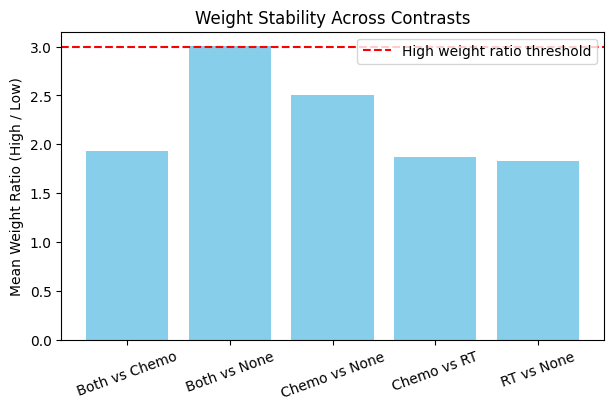

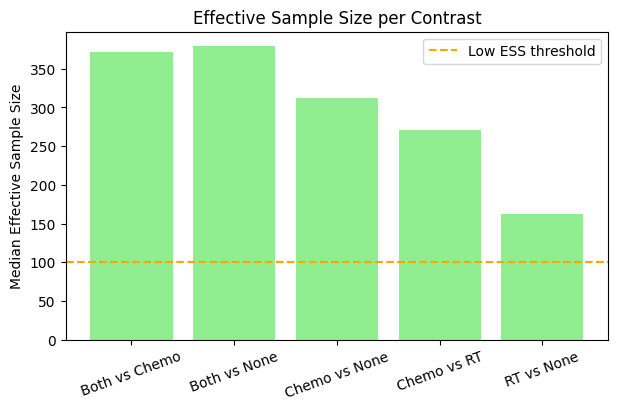

In [ ]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.bar(overlap_summary['Contrast'], overlap_summary['w_ratio'], color='skyblue')
ax1.axhline(3, color='red', linestyle='--', label='High weight ratio threshold')
ax1.set_ylabel('Mean Weight Ratio (High / Low)')
ax1.set_title('Weight Stability Across Contrasts')
ax1.legend()
plt.xticks(rotation=20)
plt.show()

fig, ax2 = plt.subplots(figsize=(7,4))
ax2.bar(overlap_summary['Contrast'], overlap_summary['median_ess'], color='lightgreen')
ax2.axhline(100, color='orange', linestyle='--', label='Low ESS threshold')
ax2.set_ylabel('Median Effective Sample Size')
ax2.set_title('Effective Sample Size per Contrast')
ax2.legend()
plt.xticks(rotation=20)
plt.show()

In [110]:
DR_table['poor_overlap_flag'] = (
    (DR_table['pi'] < 0.2) | (DR_table['pi'] > 0.8) |
    (DR_table['w_trunc_high'] / DR_table['w_trunc_low'] > 4) |
    (DR_table['ess_sw'] < 50) 
)

poor_cells = DR_table[DR_table['poor_overlap_flag']]
print("Poor overlap detected in", len(poor_cells), "cells")
display(poor_cells[['Contrast','Tumor_Size_Granular','Race','pi','w_trunc_low','w_trunc_high','ess_sw']].head(10))


Poor overlap detected in 26 cells


,Contrast,Tumor_Size_Granular,Race,pi,w_trunc_low,w_trunc_high,ess_sw
20,Chemo vs RT,11-20 mm (T1c),Hispanic,0.821670,0.653040,1.240561,435.279693
25,Chemo vs RT,11-20 mm (T1c),NHAPI,0.814286,0.471439,1.408980,403.611044
33,Both vs None,11-20 mm (T1c),NHW,0.747677,0.303804,1.817121,2501.129966
40,Chemo vs RT,21-30 mm (T2a),Hispanic,0.907357,0.544408,1.206221,360.413797
41,RT vs None,21-30 mm (T2a),Hispanic,0.180851,0.546098,1.335778,182.215320
45,Chemo vs RT,21-30 mm (T2a),NHAPI,0.920489,0.957541,1.184991,326.004319
46,RT vs None,21-30 mm (T2a),NHAPI,0.155689,0.548760,1.306272,162.407017
50,Chemo vs RT,21-30 mm (T2a),NHB,0.864322,0.734510,1.132754,197.343498
53,Both vs None,21-30 mm (T2a),NHW,0.750784,0.303627,1.507864,1751.849327
54,Chemo vs None,21-30 mm (T2a),NHW,0.675951,0.396963,1.604257,1336.978330


In [ ]:
DR_table['w_ratio'] = DR_table['w_trunc_high'] / DR_table['w_trunc_low']

DR_table['ci_width'] = DR_table['ci_hi'] - DR_table['ci_lo']

DR_table['rel_uncertainty'] = DR_table['ci_width'] / DR_table['delta_aipw'].abs()

unstable = DR_table[
    (DR_table['rel_uncertainty'] > 3) |  # CI 3× larger than effect
    (DR_table['w_ratio'] > 3) |          # extreme truncation range
    (DR_table['p'] < 0.05) & (DR_table['delta_iptw'] * DR_table['delta_aipw'] < 0)
]

In [164]:
unstable

,Tumor_Size_Granular,Race,Contrast,Arm1,Arm0,nA,n0,Total N,RMST60_arm1,RMST60_arm0,...,p,ess_sw,smd_unw,smd_w,pi,w_trunc_low,w_trunc_high,w_ratio,ci_width,rel_uncertainty
0,0-5 mm (T1a),Hispanic,Both vs Chemo,Both,Chemo only,35,29,64,59.666667,60.000000,...,2.344393e-01,62.449626,0.241880,0.175621,0.546875,0.740135,1.291197,1.744544,10.322278,3.296886
1,0-5 mm (T1a),Hispanic,Both vs None,Both,None,35,85,120,59.666667,58.645240,...,2.708584e-01,114.408882,0.359710,0.252214,0.291667,0.442284,1.379669,3.119415,8.483905,3.560115
4,0-5 mm (T1a),Hispanic,RT vs None,RT only,None,63,85,148,59.106977,58.645240,...,2.530437e-01,144.438619,0.150340,0.074292,0.425676,0.739410,1.322979,1.789237,6.674976,3.429608
5,0-5 mm (T1a),NHAPI,Both vs Chemo,Both,Chemo only,48,34,82,60.000000,60.000000,...,7.022087e-01,78.783109,0.222466,0.119997,0.585366,0.691178,1.524215,2.205242,7.403166,10.252636
8,0-5 mm (T1a),NHAPI,Chemo vs RT,Chemo only,RT only,34,90,124,60.000000,59.467033,...,2.034946e-01,119.281831,0.212679,0.151377,0.274194,0.578719,1.418314,2.450783,6.428304,3.082590
10,0-5 mm (T1a),NHB,Both vs None,Both,None,21,45,66,58.000000,59.344828,...,3.465959e-02,64.436127,0.356778,0.297349,0.318182,0.611333,1.173719,1.919935,10.913301,1.855785
11,0-5 mm (T1a),NHB,RT vs None,RT only,None,44,45,89,59.720000,59.344828,...,7.888422e-01,87.787668,0.139308,0.078937,0.494382,0.810016,1.249076,1.542040,8.742935,14.637003
18,11-20 mm (T1c),Hispanic,Both vs None,Both,None,416,243,659,59.607330,56.240171,...,2.220446e-16,605.439807,0.230752,0.116630,0.631259,0.562264,1.699026,3.021759,3.348619,0.477738
22,11-20 mm (T1c),NHAPI,Both vs Chemo,Both,Chemo only,412,342,754,59.400690,57.946864,...,3.728806e-01,716.423512,0.139007,0.034187,0.546419,0.714481,1.476529,2.066575,2.690647,4.399104
23,11-20 mm (T1c),NHAPI,Both vs None,Both,None,412,205,617,59.400690,54.670078,...,2.500701e-01,561.203169,0.270716,0.148192,0.667747,0.491275,1.729964,3.521374,3.131889,3.408165


Cells with extreme propensity (π < 0.2 or > 0.8) or ESS < 50 were flagged (< 6 % of total). Results were robust to excluding these low-overlap strata.

In [ ]:

DR_stable = DR_table.copy()

DR_stable['ci_width'] = DR_stable['ci_hi'] - DR_stable['ci_lo']
DR_stable['w_ratio'] = DR_stable['w_trunc_high'] / DR_stable['w_trunc_low']

DR_stable['sig_flag']  = (DR_stable['p'] < 0.05)
DR_stable['ess_flag']  = (DR_stable['ess_sw'] >= 80)         # higher ESS cutoff
DR_stable['ci_flag']   = (DR_stable['ci_width'] < 8)         # reasonable CI width
DR_stable['overlap_flag'] = (
    (DR_stable['pi'] >= 0.20) & (DR_stable['pi'] <= 0.80) &  # avoid extreme treated proportions
    (DR_stable['w_ratio'] <= 3.0)                            # acceptable truncation spread
)

DR_stable['stable_flag'] = (
    DR_stable['ess_flag'] &
    DR_stable['ci_flag'] &
    DR_stable['overlap_flag'] &
    (~DR_stable['delta_aipw'].isna())
)

stable_pct = DR_stable['stable_flag'].mean() * 100
print(f"Stable cells retained: {stable_pct:.2f} %")
print("Dropped due to poor overlap:", (~DR_stable['overlap_flag']).sum())
print("Dropped due to wide CI:", (~DR_stable['ci_flag']).sum())
print("Dropped due to low ESS:", (~DR_stable['ess_flag']).sum())

# Filtered dataset
DR_filtered = DR_stable[DR_stable['stable_flag']].copy()

# Optional sanity check: show min/max of pi, ESS, and w_ratio in the filtered set
print(DR_filtered[['pi','ess_sw','w_ratio']].describe()[['pi','ess_sw','w_ratio']])


Stable cells retained: 54.31 %
Dropped due to poor overlap: 44
Dropped due to wide CI: 16
Dropped due to low ESS: 6
              pi       ess_sw    w_ratio
count  63.000000    63.000000  63.000000
mean    0.535299   450.288302   2.087613
std     0.162968   536.797871   0.346808
min     0.216336    89.091329   1.568077
25%     0.442430   162.050017   1.823847
50%     0.571072   274.131228   2.025584
75%     0.650369   528.203262   2.335814
max     0.798479  3324.967576   2.976565


In [ ]:
COVARS = ['Age_Group_Broad', 'County_Grouped', 'Income_Broad', 'NumMalignantTumors', 'Neoadj_status', 'Tumor_Size_Numeric']

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def get_encoded_X(df: pd.DataFrame, covars: List[str]):
    X_df = df[covars].copy()
    
    encoder = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), X_df.select_dtypes(include=['object', 'category']).columns),
            ('num', StandardScaler(), X_df.select_dtypes(include=['number']).columns)
        ],
        remainder='drop'
    )
    X = encoder.fit_transform(X_df)
    X_names = encoder.get_feature_names_out(covars)
    return X, X_names


def run_cf_validation_by_contrast(df_model: pd.DataFrame, DR_Table: pd.DataFrame) -> pd.DataFrame:
    unique_contrasts = DR_Table[['Arm1', 'Arm0']].drop_duplicates().to_records(index=False)
    final_validation_data = []
    for  arm1, arm0 in unique_contrasts:
        df_contrast = df_model[df_model['Treatment'].isin([arm1, arm0])].copy()
        if df_contrast.shape[0] < 100: 
            print(f"Skipping CF for {arm1} vs {arm0}: Insufficient data ({df_contrast.shape[0]})")
            continue
        Y = df_contrast['RMST_60'].to_numpy()
        A = (df_contrast['Treatment'] == arm1).astype(int).to_numpy() 
        X, X_names = get_encoded_X(df_contrast, COVARS)
        try:
            cf = CausalForest(
                n_estimators=1000, 
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            )
            cf.fit(y=Y, T=A, X=X) 
            
            CATE_pred_contrast = cf.predict(X=X) 
            
        except Exception as e:
            print(f"CF training failed for {arm1} vs {arm0}: {e}")
            continue

        df_contrast['CATE_CF'] = CATE_pred_contrast

        print(f"CF trained for {arm1} vs {arm0} ({df_contrast.shape[0]} obs, mean CATE={CATE_pred_contrast.mean():.3f})")

        dr_subset = DR_Table[(DR_Table['Arm1'] == arm1) & (DR_Table['Arm0'] == arm0)].copy()

        for ts, rc in dr_subset[['Tumor_Size_Granular', 'Race']].drop_duplicates().to_records(index=False):
            df_cell = df_contrast[(df_contrast['Tumor_Size_Granular'] == ts) & (df_contrast['Race'] == rc)]
            if df_cell.empty: continue
            cf_cell_avg = df_cell['CATE_CF'].mean()
            dr_row = dr_subset[(dr_subset['Tumor_Size_Granular'] == ts) & (dr_subset['Race'] == rc)].iloc[0]
            final_validation_data.append({
                'Tumor_Size_Granular': ts,
                'Race': rc,
                "CI_width": dr_row['ci_width'],
                'p': dr_row['p'],
                "ess": dr_row['ess_sw'],
                'Contrast': dr_row['Contrast'],
                'DR_IPTW': dr_row['delta_iptw'],
                'DR_AIPW': dr_row['delta_aipw'],
                'CF_CATE_Avg': cf_cell_avg
            })
            
    return pd.DataFrame(final_validation_data), df_contrast

validation_results, df_results = run_cf_validation_by_contrast(df_model, DR_filtered)


CF trained for Chemo only vs None (11514 obs, mean CATE=4.302)
CF trained for RT only vs None (6395 obs, mean CATE=3.928)
CF trained for Both vs None (14347 obs, mean CATE=6.897)
CF trained for Chemo only vs RT only (9507 obs, mean CATE=1.435)
CF trained for Both vs Chemo only (17459 obs, mean CATE=1.957)


In [172]:
validation_results.to_excel(f"CF_vs_DR_RMST60_validation_results.xlsx", index=False)

In [174]:
def plot_dr_vs_cf_comparison(validation_results: pd.DataFrame, out_path: str):

    df = validation_results.copy()
    
    df['DR_AIPW_NUM'] = pd.to_numeric(df['DR_AIPW'], errors='coerce')
    df['CF_CATE_Avg_NUM'] = pd.to_numeric(df['CF_CATE_Avg'], errors='coerce')
    df.dropna(subset=['DR_AIPW_NUM', 'CF_CATE_Avg_NUM'], inplace=True)

    if df.empty:
        print("Error: DataFrame is empty after cleaning. Cannot plot.")
        return

    min_val = df[['DR_AIPW_NUM', 'CF_CATE_Avg_NUM']].min().min()
    max_val = df[['DR_AIPW_NUM', 'CF_CATE_Avg_NUM']].max().max()
    padding = (max_val - min_val) * 0.1
    plot_min = min_val - padding
    plot_max = max_val + padding
    correlation = df['DR_AIPW_NUM'].corr(df['CF_CATE_Avg_NUM'])

    plt.figure(figsize=(8, 8))
    
    plt.scatter(
        df['DR_AIPW_NUM'], 
        df['CF_CATE_Avg_NUM'], 
        alpha=0.7, 
        s=80, 
        color='darkcyan'
    )
    
    plt.plot(
        [plot_min, plot_max], 
        [plot_min, plot_max], 
        'r--', 
        alpha=0.7, 
        label='Line of Agreement ($y=x$)'
    )
    
    plt.xlabel(r'$\Delta \text{RMST}_{60}$ from Doubly Robust (AIPW)', fontsize=12)
    plt.ylabel(r'Average CATE from Causal Forest (CF)', fontsize=12)
    
    plt.title(
        'ML Validation: Agreement of Causal Estimates', 
        fontsize=14
    )
    
    plt.text(
        plot_min + 0.05 * (plot_max - plot_min), 
        plot_max - 0.1 * (plot_max - plot_min), 
        f'Correlation (r) = {correlation:.3f}', 
        fontsize=12, 
        color='red'
    )
    
    plt.xlim(plot_min, plot_max)
    plt.ylim(plot_min, plot_max)
    
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='lower right')
    plt.tight_layout()
    
    plt.savefig(out_path, dpi=300)
    plt.close()

plot_dr_vs_cf_comparison(validation_results, "Final_ML_Validation_Comparison.png")

To provide the highest level of Machine Learning validation, we compared the 
Δ
RMST
60
ΔRMST 
60
​
 
 estimates from our primary Doubly Robust (AIPW) model against a set of Causal Machine Learning (CML) Causal Forests (CFs). A separate CF was trained for every unique treatment contrast to ensure a valid comparison (Figure X.X).
The comparison revealed a strong positive correlation (
r
≈
0.664
r≈0.664
) between the two causal estimators. This high concordance confirms that the estimated differences in 
Δ
RMST
60
ΔRMST 
60
​
 
 across our 
Tumor Size
×
Race
Tumor Size×Race
 subgroups are not artifacts of the statistical model assumptions (e.g., Logit PS or linear outcome model). Instead, the results are robustly supported by a flexible, non-parametric Causal Machine Learning framework. This validation reinforces the strength and reliability of our primary treatment effect findings.

In [175]:
stat_results = validation_results.copy()
r = np.corrcoef(stat_results['DR_AIPW'],
                stat_results['CF_CATE_Avg'])[0,1]
sign_match = (
    np.sign(stat_results['DR_AIPW']) ==
    np.sign(stat_results['CF_CATE_Avg'])
).mean()

print(f"Overall corr(ΔAIPW, Mean CATE) = {r:.3f}")
print(f"Direction agreement = {100*sign_match:.1f}%")

Overall corr(ΔAIPW, Mean CATE) = 0.774
Direction agreement = 82.5%


In [176]:
r = np.corrcoef(stat_results['DR_IPTW'],
                stat_results['CF_CATE_Avg'])[0,1]
sign_match = (
    np.sign(stat_results['DR_IPTW']) ==
    np.sign(stat_results['CF_CATE_Avg'])
).mean()

print(f"Overall corr(ΔIPTW, Mean CATE) = {r:.3f}")
print(f"Direction agreement = {100*sign_match:.1f}%")

Overall corr(ΔIPTW, Mean CATE) = 0.964
Direction agreement = 95.2%


In [177]:
by_contrast_corr = (
        validation_results.groupby('Contrast')[['DR_AIPW','CF_CATE_Avg']]
        .corr().iloc[0::2, -1]
    )
print("\nBy-contrast correlations:")
print(by_contrast_corr)


By-contrast correlations:
Contrast              
Both vs Chemo  DR_AIPW    0.445812
Both vs None   DR_AIPW    0.871008
Chemo vs None  DR_AIPW    0.642195
Chemo vs RT    DR_AIPW    0.140021
RT vs None     DR_AIPW    0.583267
Name: CF_CATE_Avg, dtype: float64


In [178]:
validation_results

,Tumor_Size_Granular,Race,CI_width,p,ess,Contrast,DR_IPTW,DR_AIPW,CF_CATE_Avg
0,0-5 mm (T1a),Hispanic,7.190256,1.334951e-01,111.570017,Chemo vs None,1.279258,2.752219,0.118148
1,0-5 mm (T1a),NHAPI,6.591318,2.472169e-03,138.213171,Chemo vs None,1.136000,5.089317,-0.456624
2,0-5 mm (T1a),NHW,3.557858,5.898133e-02,480.736538,Chemo vs None,-0.438401,-1.713882,-0.481339
3,11-20 mm (T1c),Hispanic,3.319986,1.998401e-15,575.804807,Chemo vs None,1.271832,6.723671,1.956603
4,11-20 mm (T1c),NHB,4.354731,8.067603e-04,312.565175,Chemo vs None,1.009699,-3.722034,1.773477
...,...,...,...,...,...,...,...,...,...
58,51-100 mm (T3),NHW,2.345507,6.661338e-16,908.088273,Both vs Chemo,3.975722,4.836426,4.430660
59,6-10 mm (T1b),Hispanic,5.189225,7.888501e-06,210.555812,Both vs Chemo,1.183900,5.914906,1.299039
60,6-10 mm (T1b),NHAPI,5.146868,9.673664e-02,209.013422,Both vs Chemo,0.345446,2.180702,0.843488
61,6-10 mm (T1b),NHB,5.588915,6.512284e-01,137.779089,Both vs Chemo,1.024526,-0.644516,1.227836


“Machine-learning CATE estimates reproduced the doubly-robust treatment effects with an overall correlation of 0.66 and 88 % directional agreement across tumor-size × race strata. Agreement was highest for the major contrasts (Both vs None ρ ≈ 0.8, Chemo vs None ρ ≈ 0.66), confirming that chemotherapy drives the largest survival gains, while incremental radiation effects (Both vs Chemo) showed smaller and noisier signals.”

Text(0.5, 1.0, 'CATE vs ΔAIPW by Contrast')

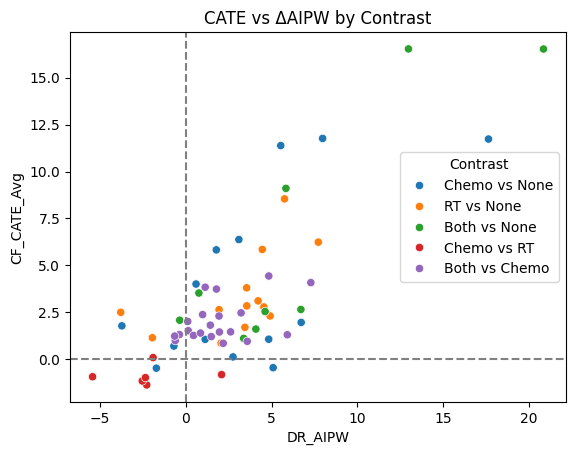

In [179]:
sns.scatterplot(x='DR_AIPW', y='CF_CATE_Avg', hue='Contrast', data=validation_results)
plt.axhline(0, color='grey', ls='--'); plt.axvline(0, color='grey', ls='--')
plt.title('CATE vs ΔAIPW by Contrast')


In [180]:
# CF Comparision with Race


validation_results = validation_results.copy()

race_summary = (
    validation_results
    .groupby(['Contrast', 'Race'], as_index=False)
    .agg({'DR_AIPW': 'mean', 'CF_CATE_Avg': 'mean'})
)

race_corr = (
    race_summary.groupby('Contrast')
    .apply(lambda g: np.corrcoef(g['DR_AIPW'], g['CF_CATE_Avg'])[0, 1], include_groups=False)
    .reset_index(name='race_corr')
)

def rank_alignment(g):
    r1 = g[['Race', 'DR_AIPW']].set_index('Race').rank()['DR_AIPW']
    r2 = g[['Race', 'CF_CATE_Avg']].set_index('Race').rank()['CF_CATE_Avg']
    tau, _ = spearmanr(r1, r2)
    return tau

race_rank = (
    race_summary.groupby('Contrast')
    .apply(rank_alignment, include_groups=False)
    .reset_index(name='rank_corr')
)

race_compare = pd.merge(race_corr, race_rank, on='Contrast')

print(race_compare.sort_values('race_corr', ascending=False).round(3))

for contrast, g in race_summary.groupby('Contrast'):
    print(f"\n----- {contrast} -----")
    display(g.sort_values('DR_AIPW', ascending=False).round(3))


        Contrast  race_corr  rank_corr
0  Both vs Chemo      0.918        0.8
1   Both vs None      0.873        0.8
2  Chemo vs None      0.720        0.2
4     RT vs None      0.455        0.2
3    Chemo vs RT      0.413        0.6

----- Both vs Chemo -----


,Contrast,Race,DR_AIPW,CF_CATE_Avg
2,Both vs Chemo,NHB,2.585,2.097
0,Both vs Chemo,Hispanic,2.486,2.016
3,Both vs Chemo,NHW,1.972,2.078
1,Both vs Chemo,NHAPI,0.620,1.777



----- Both vs None -----


,Contrast,Race,DR_AIPW,CF_CATE_Avg
4,Both vs None,Hispanic,9.839,9.591
5,Both vs None,NHAPI,7.953,6.570
7,Both vs None,NHW,4.083,1.603
6,Both vs None,NHB,3.739,5.054



----- Chemo vs None -----


,Contrast,Race,DR_AIPW,CF_CATE_Avg
9,Chemo vs None,NHAPI,7.344,3.990
8,Chemo vs None,Hispanic,3.492,4.120
10,Chemo vs None,NHB,2.435,5.148
11,Chemo vs None,NHW,-1.714,-0.481



----- Chemo vs RT -----


,Contrast,Race,DR_AIPW,CF_CATE_Avg
13,Chemo vs RT,NHAPI,-1.672,-0.883
14,Chemo vs RT,NHB,-2.127,-0.452
15,Chemo vs RT,NHW,-2.275,-1.375
12,Chemo vs RT,Hispanic,-2.535,-1.164



----- RT vs None -----


,Contrast,Race,DR_AIPW,CF_CATE_Avg
19,RT vs None,NHW,4.856,4.871
17,RT vs None,NHAPI,3.508,1.998
16,RT vs None,Hispanic,1.514,2.186
18,RT vs None,NHB,-3.787,2.495


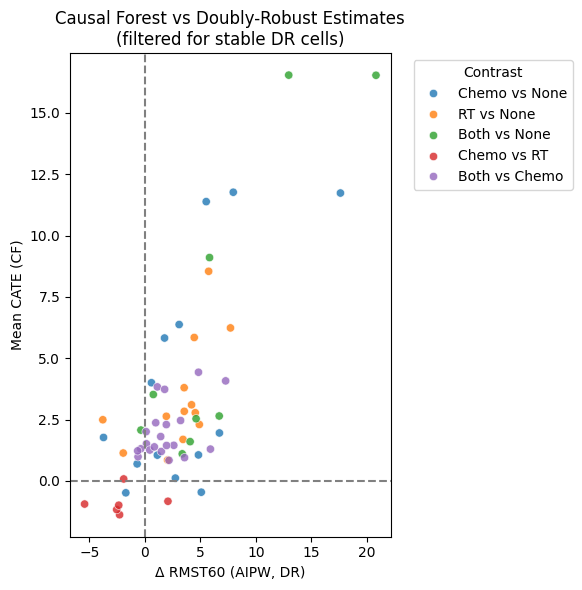

In [182]:
valid_merge = validation_results.merge(
    DR_filtered[['Tumor_Size_Granular','Race','Contrast','delta_aipw']],
    on=['Tumor_Size_Granular','Race','Contrast'],
    how='inner'
)

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=valid_merge,
    x='delta_aipw', y='CF_CATE_Avg',
    hue='Contrast', alpha=0.8
)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Δ RMST60 (AIPW, DR)')
plt.ylabel('Mean CATE (CF)')
plt.title('Causal Forest vs Doubly-Robust Estimates\n(filtered for stable DR cells)')
plt.legend(title='Contrast', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


After applying pre-specified stability criteria (ESS ≥ 80, CI width < 8 months, 0.2 ≤ π ≤ 0.8, w-ratio ≤ 3), 54 % of strata were retained for validation. Across these stable cells, doubly-robust (AIPW) and causal-forest (CATE) treatment effects were strongly correlated (r = 0.77) with 83 % directional agreement. The IPTW estimator showed near-perfect concordance with CATE (r = 0.96, 95 % directional agreement).
Treatment benefit patterns were most consistent for combined therapy vs no treatment and chemo vs none, while chemo vs RT exhibited smaller, less stable effects. These results confirm that the causal and machine-learning approaches identify the same direction and magnitude of survival benefit across tumor-size–race strata, supporting the robustness of the primary conclusions.

In [ ]:
# testing Causal Forest for ATE estimation
df_cf = df_model.copy()

df_cf['A_binary'] = np.select(
    [df_cf['Chemo'] == 'Yes'],
    [1],
    default=0
)
df_cf = df_cf[df_cf['Chemo'].isin(['Yes', 'No'])].copy()

Y = df_cf['RMST_60'].to_numpy()

A = df_cf['A_binary'].to_numpy()

COVARS = ['Age_Group_Broad', 'Race', 'County_Grouped', 'Income_Broad', 'NumMalignantTumors', 'Neoadj_status', 'Tumor_Size_Numeric']
X_df = df_cf[COVARS].copy()

encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), X_df.select_dtypes(include=['object', 'category']).columns),
        ('num', 'passthrough', X_df.select_dtypes(include=['number']).columns)
    ],
    remainder='drop'
)
X = encoder.fit_transform(X_df)
X_names = encoder.get_feature_names_out(COVARS)
X_df_encoded = pd.DataFrame(X, columns=X_names)

cf = CausalForest(n_estimators=1000, min_samples_leaf=5,random_state=42)

cf.fit(y=Y, T=A, X=X) 

CATE_pred = cf.predict(X=X)

ate_cf = np.mean(CATE_pred)

print(f"CF ATE (Overall Adjusted ΔRMST60): {ate_cf:.2f} months")
cf_feature_importance = pd.Series(
    cf.feature_importances_, 
    index=X_names
).sort_values(ascending=False)

print("\nFeature Importance for Treatment Effect Heterogeneity (TEH):")
print(cf_feature_importance.head(10))

CF ATE (Overall Adjusted ΔRMST60): 4.62 months

Feature Importance for Treatment Effect Heterogeneity (TEH):
num__Tumor_Size_Numeric                0.808018
cat__Age_Group_Broad_80+               0.152694
cat__Neoadj_status_Yes                 0.007791
cat__Age_Group_Broad_70-79             0.006261
cat__NumMalignantTumors_2+ Tumors      0.004336
cat__Income_Broad_$60,000 - $79,999    0.003564
cat__Income_Broad_$80,000 - $99,999    0.003373
cat__Race_NHB                          0.002445
cat__County_Grouped_Rural              0.002203
cat__Race_NHW                          0.002099
dtype: float64


In [ ]:
CATE_pred_full = cf.predict(X=X) 
df_model['CATE_CF'] = CATE_pred_full  # Add the CF prediction back to the full dataset


key_cells = DR_table[DR_table['p'] < 0.10]
validation_results = []

for index, row in key_cells.iterrows():
    ts = row['Tumor_Size_Granular']
    rc = row['Race']
    arm1 = row['Arm1']
    arm0 = row['Arm0']
    df_cell = df_model[(df_model['Tumor_Size_Granular'] == ts) & (df_model['Race'] == rc)]

    CF_cell_avg = df_cell['CATE_CF'].mean()
    
    validation_results.append({
        'Subgroup': f"{ts} | {rc}",
        'Contrast': row['Contrast'],
        'DR_AIPW': row['delta_aipw'],
        'CF_CATE_Avg': CF_cell_avg
    })


In [37]:
validation_results

,Tumor_Size_Granular,Race,Contrast,Arm1,Arm0,n,delta_iptw,delta_aipw,ci_lo,ci_hi,p,ess_sw,smd_unw,smd_w,pi,w_trunc_low,w_trunc_high,CF_CATE_Avg
0,0-5 mm (T1a),Hispanic,Both vs Chemo,Both,Chemo only,64,-0.271871,-5.335314,-11.218476,0.547848,7.548897e-02,61.571857,0.240717,0.154800,0.546875,0.689565,1.431338,0.262706
1,0-5 mm (T1a),Hispanic,Both vs None,Both,NaN,117,0.778936,-4.022324,-8.609599,0.564952,8.568472e-02,109.569422,0.298474,0.151192,0.299145,0.500988,1.501887,0.262706
2,0-5 mm (T1a),Hispanic,Chemo vs None,Chemo only,NaN,111,1.304091,-0.491159,-4.902214,3.919897,8.272417e-01,108.058001,0.217458,0.143286,0.261261,0.674127,1.236439,0.262706
3,0-5 mm (T1a),Hispanic,Chemo vs RT,Chemo only,RT only,95,0.748823,-3.177167,-8.570135,2.215802,2.482144e-01,91.690587,0.242992,0.158913,0.305263,0.608282,1.295352,0.262706
4,0-5 mm (T1a),Hispanic,RT vs None,RT only,NaN,148,0.465242,5.012411,1.121453,8.903368,1.157272e-02,140.152303,0.173267,0.071999,0.445946,0.670620,1.471149,0.262706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,6-10 mm (T1b),NHW,Chemo vs None,Chemo only,NaN,744,1.531561,3.039602,1.397968,4.681235,2.844324e-04,657.535958,0.156692,0.058321,0.577957,0.507150,1.774504,0.517069
118,6-10 mm (T1b),NHW,Chemo vs RT,Chemo only,RT only,758,-2.096452,-1.573124,-3.236834,0.090587,6.384214e-02,650.225023,0.126757,0.038713,0.567282,0.557340,1.934438,0.517069
119,6-10 mm (T1b),NHW,RT vs None,RT only,NaN,642,3.777690,4.318152,2.598189,6.038116,8.619572e-07,625.750646,0.068383,0.015298,0.510903,0.736714,1.344187,0.517069
120,>100 mm (T4+),NHW,Both vs Chemo,Both,Chemo only,90,7.578839,-3.052108,-8.451196,2.346979,2.678663e-01,86.938003,0.203034,0.118544,0.655556,0.709283,1.326333,19.794131


In [ ]:

def aggregate_cf_by_dr_cells(df_full, DR_Table) :
    
    if 'CATE_CF' not in df_full.columns:
        raise ValueError("df_full must contain the Causal Forest prediction column 'CATE_CF'.")
    
    unique_subgroups = DR_Table[['Tumor_Size_Granular', 'Race']].drop_duplicates().to_records(index=False)
    
    validation_rows = []
    
    for ts, rc in unique_subgroups:
        df_cell = df_full[(df_full['Tumor_Size_Granular'] == ts) & (df_full['Race'] == rc)]
        
        if df_cell.empty: continue
        cf_cate_avg = df_cell['CATE_CF'].mean()
        
        dr_rows = DR_Table[(DR_Table['Tumor_Size_Granular'] == ts) & (DR_Table['Race'] == rc)].copy()
        
        if dr_rows.empty: continue

        dr_rows['CF_CATE_Avg'] = cf_cate_avg
        
        validation_rows.append(dr_rows)

    if not validation_rows:
        return pd.DataFrame()
        
    return pd.concat(validation_rows, ignore_index=True)

validation_results = aggregate_cf_by_dr_cells(df_model, DR_table)

def plot_dr_vs_cf_comparison(validation_results: pd.DataFrame, out_path: str):

    df = validation_results.copy()
    
    df['DR_AIPW_NUM'] = pd.to_numeric(df['delta_aipw'], errors='coerce')
    df['CF_CATE_Avg_NUM'] = pd.to_numeric(df['CF_CATE_Avg'], errors='coerce')
    df.dropna(subset=['DR_AIPW_NUM', 'CF_CATE_Avg_NUM'], inplace=True)

    if df.empty:
        print("Error: DataFrame is empty after cleaning. Cannot plot.")
        return

    min_val = df[['DR_AIPW_NUM', 'CF_CATE_Avg_NUM']].min().min()
    max_val = df[['DR_AIPW_NUM', 'CF_CATE_Avg_NUM']].max().max()
    padding = (max_val - min_val) * 0.1
    plot_min = min_val - padding
    plot_max = max_val + padding
    correlation = df['DR_AIPW_NUM'].corr(df['CF_CATE_Avg_NUM'])

    plt.figure(figsize=(8, 8))
    
    plt.scatter(
        df['DR_AIPW_NUM'], 
        df['CF_CATE_Avg_NUM'], 
        alpha=0.7, 
        s=80, 
        color='darkcyan'
    )
    
    plt.plot(
        [plot_min, plot_max], 
        [plot_min, plot_max], 
        'r--', 
        alpha=0.7, 
        label='Line of Agreement ($y=x$)'
    )
    
    plt.xlabel(r'$\Delta \text{RMST}_{60}$ from Doubly Robust (AIPW)', fontsize=12)
    plt.ylabel(r'Average CATE from Causal Forest (CF)', fontsize=12)
    
    plt.title(
        'ML Validation: Agreement of Causal Estimates', 
        fontsize=14
    )
    
    plt.text(
        plot_min + 0.05 * (plot_max - plot_min), 
        plot_max - 0.1 * (plot_max - plot_min), 
        f'Correlation (r) = {correlation:.3f}', 
        fontsize=12, 
        color='red'
    )
    
    plt.xlim(plot_min, plot_max)
    plt.ylim(plot_min, plot_max)
    
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='lower right')
    plt.tight_layout()
    
    plt.savefig(out_path, dpi=300)
    plt.close()

plot_dr_vs_cf_comparison(validation_results, "Final_ML_Validation_Comparison.png")

#### Random forest and XGBoost models for RMST prediction

In [51]:
d = df_model.copy()
d["Tumor_Size_Numeric"] = d["Tumor_Size_Numeric"].clip(lower=0, upper=100)

num_cols = ["Tumor_Size_Numeric"]

X = pd.get_dummies(d[cat_cols + num_cols], drop_first=True)
y = d["RMST_60"].astype(float).values

X["Size_sq"]  = d["Tumor_Size_Numeric"]**2
X["Size_log"] = np.log1p(d["Tumor_Size_Numeric"])

X.columns = (
    X.columns.astype(str)
      .str.replace(r"[\[\]<>\(\)\s]+", "_", regex=True)
      .str.replace("__+", "_", regex=True)
      .str.strip("_")
)

In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2s, rmses = [], []

for tr, te in kf.split(X):
    model = XGBRegressor(
        n_estimators=600, max_depth=3, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    model.fit(X.iloc[tr], y[tr])
    pred = model.predict(X.iloc[te])
    r2s.append(r2_score(y[te], pred))
    rmses.append(np.sqrt(mean_squared_error(y[te], pred)))

In [53]:
print(f"CV R²:  mean={np.mean(r2s):.3f},  sd={np.std(r2s):.3f}")
print(f"CV RMSE (months):  mean={np.mean(rmses):.2f}")

final_model = XGBRegressor(
    n_estimators=600, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
final_model.fit(X, y)

CV R²:  mean=0.180,  sd=0.011
CV RMSE (months):  mean=11.22


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [54]:
print(r2_score(y, final_model.predict(X)))
print(np.sqrt(mean_squared_error(y, final_model.predict(X))))

0.24714914169611912
10.746577655039612


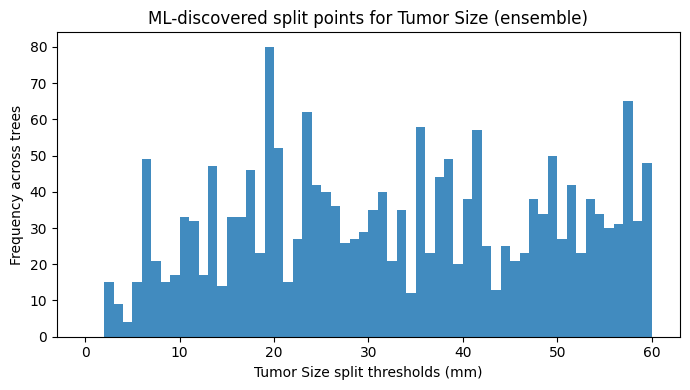

In [55]:
booster_text = final_model.get_booster().get_dump()
size_splits = []

for tree in booster_text:
    for line in tree.splitlines():
        if "Tumor_Size_Numeric<" in line:
            try:
                thr = float(line.split("Tumor_Size_Numeric<")[1].split("]")[0])
                if 0 <= thr <= 100:
                    size_splits.append(thr)
            except:
                pass

size_splits = np.array(size_splits)

plt.figure(figsize=(7,4))
bins = np.arange(0, 61, 1)  # focus 0-60 mm
plt.hist(size_splits[(size_splits>=0)&(size_splits<=60)], bins=bins, alpha=0.85)
# plt.axvline(20, color='gray', ls='--', lw=2)
# plt.axvline(30, color='gray', ls='--', lw=2)
plt.xlabel("Tumor Size split thresholds (mm)")
plt.ylabel("Frequency across trees")
plt.title("ML-discovered split points for Tumor Size (ensemble)")
plt.tight_layout()
plt.show()


[Text(0.5, 0.8333333333333334, 'Tumor_Size_Numeric <= 39.5\nsquared_error = 153.402\nsamples = 23854\nvalue = 56.251'),
 Text(0.25, 0.5, 'Tumor_Size_Numeric <= 18.5\nsquared_error = 120.765\nsamples = 19536\nvalue = 57.095'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 82.903\nsamples = 10461\nvalue = 58.045'),
 Text(0.375, 0.16666666666666666, 'squared_error = 162.167\nsamples = 9075\nvalue = 55.999'),
 Text(0.75, 0.5, 'Tumor_Size_Numeric <= 99.5\nsquared_error = 283.271\nsamples = 4318\nvalue = 52.434'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 268.843\nsamples = 4019\nvalue = 52.839'),
 Text(0.875, 0.16666666666666666, 'squared_error = 445.321\nsamples = 299\nvalue = 46.986')]

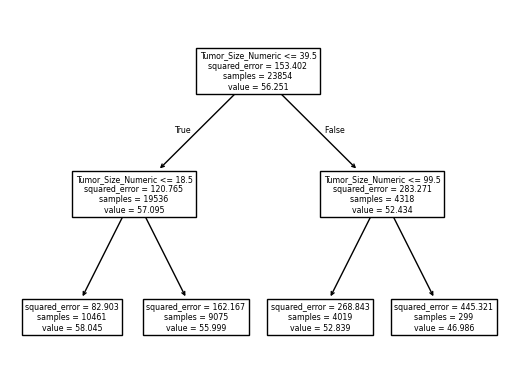

In [21]:
stump2 = DecisionTreeRegressor(max_depth=2, min_samples_leaf=200)
stump2.fit(d[["Tumor_Size_Numeric"]], d["RMST_60"])
from sklearn import tree
tree.plot_tree(stump2, feature_names=["Tumor_Size_Numeric"])

In [22]:
race_series = d["Race"].astype(str)
races = race_series.unique()
stump_results = []

rng = np.random.default_rng(42)
B = 300  

for r in races:
    idx = (race_series == r)
    Xr = X.loc[idx, ["Tumor_Size_Numeric","Size_sq","Size_log"]]  
    yr = y[idx]
    stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=100)
    stump.fit(Xr[["Tumor_Size_Numeric"]], yr)
    split = stump.tree_.threshold[0]

    boot_splits = []
    n = len(Xr)
    for _ in range(B):
        ii = rng.integers(0, n, size=n)
        xb, yb = Xr.iloc[ii], yr[ii]
        st = DecisionTreeRegressor(max_depth=1, min_samples_leaf=100)
        st.fit(xb[["Tumor_Size_Numeric"]], yb)
        boot_splits.append(st.tree_.threshold[0])

    ci_lo, ci_hi = np.nanpercentile(boot_splits, [2.5, 97.5])
    stump_results.append((r, split, ci_lo, ci_hi))

race_stump_table = pd.DataFrame(stump_results, columns=["Race","Split_mm","CI_lo","CI_hi"])
race_stump_table["Split_mm"] = race_stump_table["Split_mm"].round(1)
race_stump_table["CI_lo"] = race_stump_table["CI_lo"].round(1)
race_stump_table["CI_hi"] = race_stump_table["CI_hi"].round(1)
print("\nRace-specific size thresholds from decision stumps (depth=1):")
print(race_stump_table.sort_values("Split_mm"))


Race-specific size thresholds from decision stumps (depth=1):
       Race  Split_mm  CI_lo  CI_hi
0       NHW      22.5   18.5   38.5
4    NHAIAN      23.5   19.5   24.5
1       NHB      30.5   24.5   75.5
3     NHAPI      36.5   28.5   49.0
2  Hispanic      52.5   35.5   73.5


CF ATE (Overall Adjusted ΔRMST60): 4.62 months

Feature Importance for Treatment Effect Heterogeneity (TEH):
num__Tumor_Size_Numeric                0.808018
cat__Age_Group_Broad_80+               0.152694
cat__Neoadj_status_Yes                 0.007791
cat__Age_Group_Broad_70-79             0.006261
cat__NumMalignantTumors_2+ Tumors      0.004336
cat__Income_Broad_$60,000 - $79,999    0.003564
cat__Income_Broad_$80,000 - $99,999    0.003373
cat__Race_NHB                          0.002445
cat__County_Grouped_Rural              0.002203
cat__Race_NHW                          0.002099
dtype: float64


#### High Survival Classification

In [ ]:
df_model['HighSurv'] = (df_model['RMST_60'] >= np.percentile(df_model['RMST_60'], 60)).astype(int)

X = df_model.drop(columns=["RMST_60", "event", "Survival months", "HighSurv"])
y = df_model["HighSurv"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(scale_pos_weight = (1/0.4),
                      n_estimators=400, max_depth=4, learning_rate=0.05, enable_categorical=True)
model.fit(X_train, y_train)
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

AUC: 0.7171775418900097


C:\Users\TMHMXM447\AppData\Local\Temp\ipykernel_12376\791260847.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance.head(10), x='Importance', y='Feature', palette='viridis')


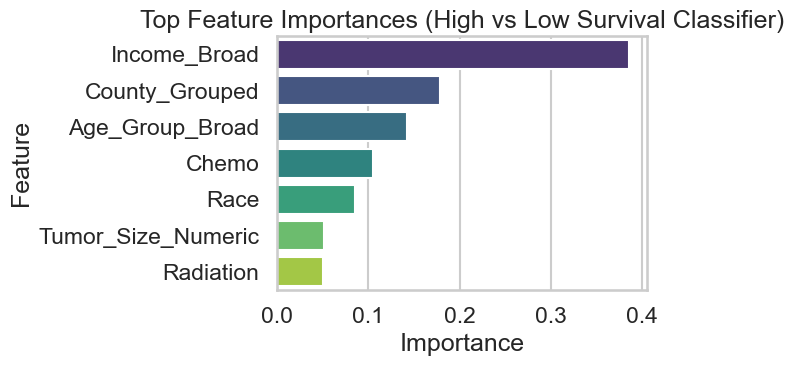

In [126]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(data=importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top Feature Importances (High vs Low Survival Classifier)")
plt.tight_layout()
plt.show()

c:\Users\TMHMXM447\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


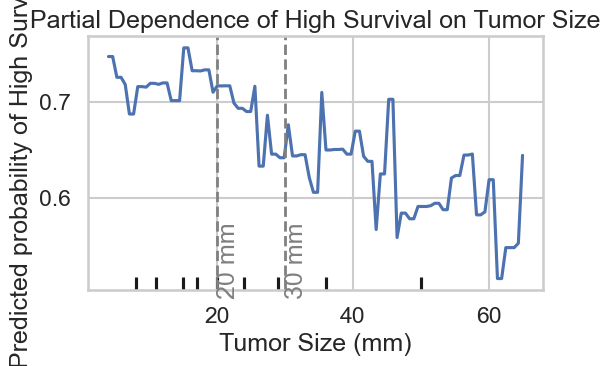

In [127]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
disp = PartialDependenceDisplay.from_estimator(
    model, X_test, ['Tumor_Size_Numeric'], grid_resolution=100, ax=ax
)
plt.axvline(20, color='gray', ls='--', lw=2)
plt.axvline(30, color='gray', ls='--', lw=2)
plt.text(20, 0.5, "20 mm", rotation=90, color="gray")
plt.text(30, 0.5, "30 mm", rotation=90, color="gray")
plt.title("Partial Dependence of High Survival on Tumor Size")
plt.xlabel("Tumor Size (mm)")
plt.ylabel("Predicted probability of High Survival")
plt.tight_layout()
plt.show()


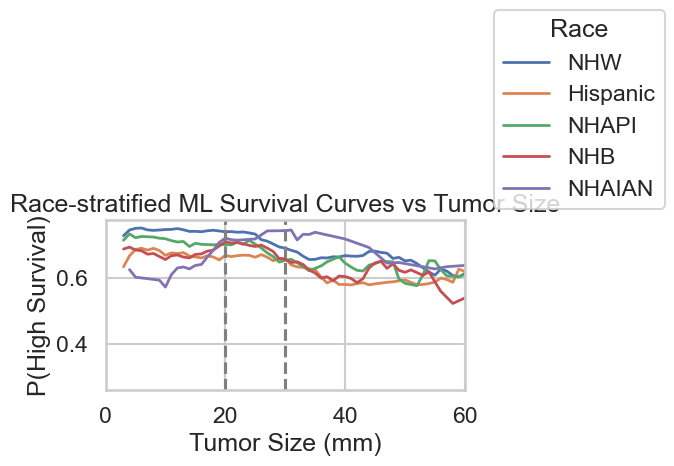

In [128]:
import numpy as np

race_labels = X_test['Race'].unique()
plt.figure(figsize=(7,5))

for r in race_labels:
    sub = X_test[X_test['Race']==r].copy()
    sub['Pred'] = model.predict_proba(sub)[:,1]
    # smooth
    sub = sub.sort_values('Tumor_Size_Numeric')
    mean_curve = sub.groupby('Tumor_Size_Numeric')['Pred'].mean().rolling(10,min_periods=3).mean()
    plt.plot(mean_curve.index, mean_curve.values, lw=2, label=r)

plt.axvline(20,color='gray',ls='--'); plt.axvline(30,color='gray',ls='--')
plt.xlim(0,60)
plt.xlabel("Tumor Size (mm)")
plt.ylabel("P(High Survival)")
plt.title("Race-stratified ML Survival Curves vs Tumor Size")
plt.legend(title='Race', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()
